## Introduction ##

`slm-theano` is a small project for calculating phase profiles for SLMs (spatial light modulators) using the power of theano and pyFFTW to avoid cost function differentiation.

For an overview of the process, take a look at [Harte et al (2014)](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-22-22-26548).
The SLM consists of an $N\times N$ phase profile $\phi_{ij}$, which is illuminated by a laser field $S_{ij}$. 
The (complex) electric field at the SLM plane is then
$$ E_{in} = A_0 S \exp(i\phi). $$
In the output plane, the (complex) electric field is
$$ E_{out} = \mathcal{F}(E_{in}), $$
where $\mathcal{F}$ denotes the 2D Fourier transform, and this gives a light intensity of
$$ I = |E_{out}|^2. $$

The goal of `slm-theano` is to perform the optimisation over $\phi_{ij}$ such that the intensity field $I_{ij}$ matches as closely as possible a target intensity field $T_{ij}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import slm
import theano
import theano.tensor as T
%matplotlib inline

Target
---------

To start, we create a target.  We assume a 256x256 SLM, which we must pad to 512x512 (Nyquist) and so the target is also 512x512.  The function `make_target_power2` just makes a inverted parabola centered on $r0$.

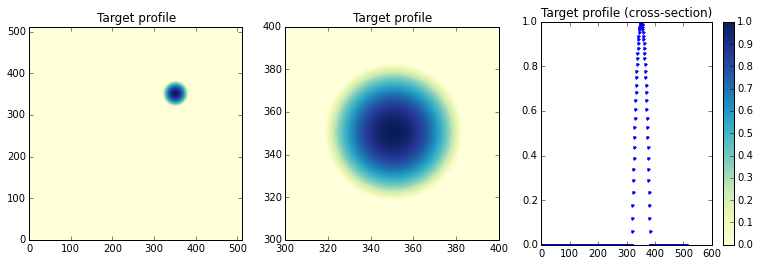

In [2]:
# SLM is NxN pixels
N = 256

N_target = 2*N

# First, generate a offset Gaussian target:
target = slm.make_target_power2(n=N_target, r0=(350,350), d=64, A=1.0)

# plot:
fig, axes = plt.subplots(ncols=3, figsize=(13,4))
cax0 = axes[0].imshow(target, extent=[0, N_target, 0, N_target], origin='lower', cmap=plt.get_cmap('YlGnBu'))
fig.colorbar(cax0, orientation ='vertical')
cax1 = axes[1].imshow(target[300:400,300:400], extent=[300, 400, 300, 400], origin='lower', cmap=plt.get_cmap('YlGnBu'))
axes[2].plot(target[350,:], '.');
axes[0].set_title('Target profile');
axes[1].set_title('Target profile');
axes[2].set_title('Target profile (cross-section)');

Weighting profile
------------------

We also want a weighting profile which will be used to weight the cost function. 
Here we have a two-level weighting profile, which will cause the cost function to heavily penalise discrepancies in the region around the target, but much less so further away. 
Setting the far-away level to something small and finite means the optimiser does not try too hard to achieve a hard zero everywhere (this is not possible), but also it will not waste too much intensity in the region away from the target.

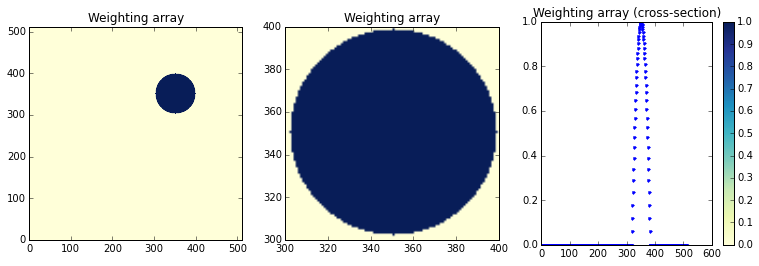

In [3]:
# Set up a weighting profile:
params = {'n': 512,
          'r0': (350, 350),
          'd': 64,
          'b': 16,
          's': 1E-6}

weighting = slm.make_weighting(**params)

# plot:
fig, axes = plt.subplots(ncols=3, figsize=(13,4))
cax = axes[0].imshow(weighting, extent=[0, N_target, 0, N_target], origin='lower', cmap=plt.get_cmap('YlGnBu'))
plt.colorbar(cax)
axes[1].imshow(weighting[300:400,300:400], extent=[300, 400, 300, 400], origin='lower', cmap=plt.get_cmap('YlGnBu'))
axes[2].plot(target[350,:], '.');
axes[0].set_title('Weighting array');
axes[1].set_title('Weighting array');
axes[2].set_title('Weighting array (cross-section)');

Laser profile
--------------

Finally we need a laser profile $S_{ij}$ which describes the illumination of the SLM. 
This can be complex to account for the phase of the illumination. 
Here we simply choose a Gaussian which illuminates most of the SLM.

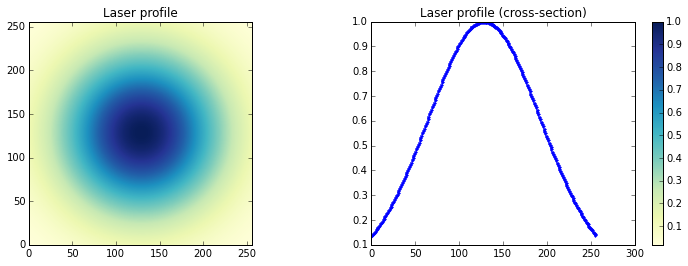

In [4]:
# First, generate a offset Gaussian target:
S_profile = slm.make_gaussian(n=N, r0=(N/2,N/2), sigma=64, A=1.0)

# plot:
fig, axes = plt.subplots(ncols=2, figsize=(13,4))
cax0 = axes[0].imshow(S_profile, extent=[0, N, 0, N], origin='lower', cmap=plt.get_cmap('YlGnBu'))
fig.colorbar(cax0, orientation ='vertical')
axes[1].plot(S_profile[128,:], '.');
axes[0].set_title('Laser profile');
axes[1].set_title('Laser profile (cross-section)');

Conjugate gradient optimisation
---------------------------------

Here comes the heart of the optimiser. 
slm.SLM contains the theano code to set up the computation at the top of this notebook, taking the phase field $\phi_{ij}$ and calculating the output field $E_\text{out}$ and intensity $I$.

In [5]:
init_phi = np.random.uniform(low=0, high=2*np.pi, size=(N**2))

slm_opt = slm.SLM(target, init_phi, S_profile, A0=1.0/1000)

Next, we define a cost function in terms of the output intensity, exposed as `slm_opt.E_out_2`. 
Here we choose a simple squared-error cost function,
$$ \mathcal{C} = \sum_{ij} \frac{1}{2}[(T_{ij} - I_{ij})W_{ij}]^2 $$
where $W_{ij}$ is the weighting array chosen earlier. 
At this stage, `cost_SE` is a computation graph expressing how to perform the computation. 
We use `theano.function` to compile this into a function we can call.

In [6]:
cost_SE   = T.sum(T.pow((slm_opt.E_out_2 - target)*weighting, 2))
cost = cost_SE

cost_fn = theano.function([], cost, on_unused_input='warn')

Using theano's automatic differentiation, we can easily get the gradient of this cost function with respect to the phase array $\phi_{ij}$

In [7]:
cost_grad = T.grad(cost, wrt=slm_opt.phi)

grad_fn = theano.function([], cost_grad, on_unused_input='warn')

We also define some helper functions since the optimiser keeps track of the current value of `phi` and expects to be able to call the function and gradient with `phi`  as an argument.

In [8]:
def wrapped_cost_fn(phi):
    slm_opt.phi.set_value(phi, borrow=True)
    return cost_fn()

def wrapped_grad_fn(phi):
    slm_opt.phi.set_value(phi, borrow=True)
    return grad_fn()

Time to run the optimiser! 
We use `fmin_cg` from the `scipy.optimize` package, and initialise with a randomised phase field. 

In [9]:
import scipy.optimize
import timeit
start_time = timeit.default_timer()
scipy.optimize.fmin_cg(
    f=wrapped_cost_fn,
    x0=init_phi,
    fprime=wrapped_grad_fn,
    disp=True,
    maxiter=100)
end_time = timeit.default_timer()

print('Ran for %.1fs' % ((end_time - start_time)))

         Current function value: 30.168881
         Iterations: 100
         Function evaluations: 202
         Gradient evaluations: 202
Ran for 5.7s


Results visualisation
--------------------------

Some plots to show how well the optimisation went.

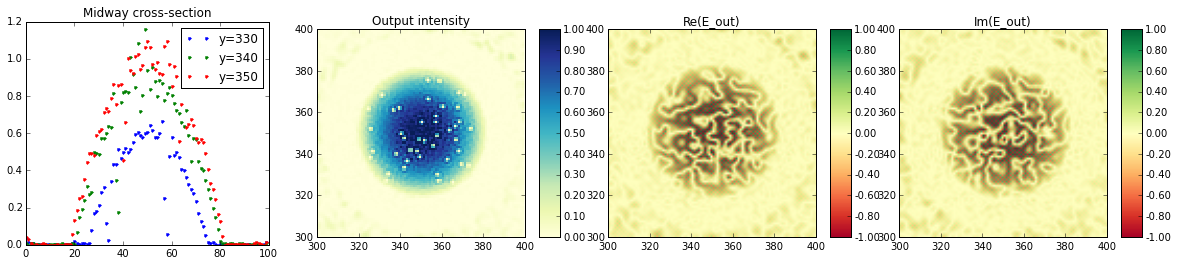

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

I_out_fn = theano.function([], slm_opt.E_out_2)
I_out = I_out_fn()


def quick_plot(I_out, E_out_r, E_out_i):
    """
    Function to make a quick plot of some cross-sections, the intensity and the 
    real/imaginary parts of the output plane
    """
    fig, axes = plt.subplots(ncols=4, figsize=(20,4))
    
    # cross-sections:
    for y in [330, 340, 350]:
        axes[0].plot(I_out[y,300:400], '.', label='y={}'.format(y));
    axes[0].legend()
    axes[0].set_title('Midway cross-section')

    # output intensity:
    cax = axes[1].imshow(I_out[300:400,300:400], 
                         extent=[300, 400, 300, 400],
                         origin='lower', 
                         interpolation='none',
                         cmap=plt.get_cmap('YlGnBu'),
                         clim=(0,1));
    axes[1].set_title('Output intensity');
    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes("right", size="10%", pad=0.2)
    cbar1 = plt.colorbar(cax, cax=cax1, format="%.2f")

    im2 = axes[2].imshow(E_out_r[300:400,300:400], 
                         extent=[300, 400, 300, 400], 
                         origin='lower', 
                         cmap=plt.get_cmap('RdYlGn'),
                         clim=(-1,1));
    axes[2].set_title('Re(E_out)')
    divider2 = make_axes_locatable(axes[2])
    cax2 = divider2.append_axes("right", size="10%", pad=0.2)
    cbar2 = plt.colorbar(im2, cax=cax2, format="%.2f")

    im3 = axes[3].imshow(E_out_i[300:400,300:400], 
                         extent=[300, 400, 300, 400],
                         origin='lower',
                         cmap=plt.get_cmap('RdYlGn'),
                         clim=(-1,1));
    axes[3].set_title('Im(E_out)');
    divider3 = make_axes_locatable(axes[3])
    cax3 = divider3.append_axes("right", size="10%", pad=0.2)
    cbar3 = plt.colorbar(im3, cax=cax3, format="%.2f")
    

# real/imag parts of output field:
E_out_fn_r = theano.function([], slm_opt.E_out_r)
E_out_fn_i = theano.function([], slm_opt.E_out_i)

E_out_r = E_out_fn_r()
E_out_i = E_out_fn_i()
    
quick_plot(I_out, E_out_r, E_out_i)

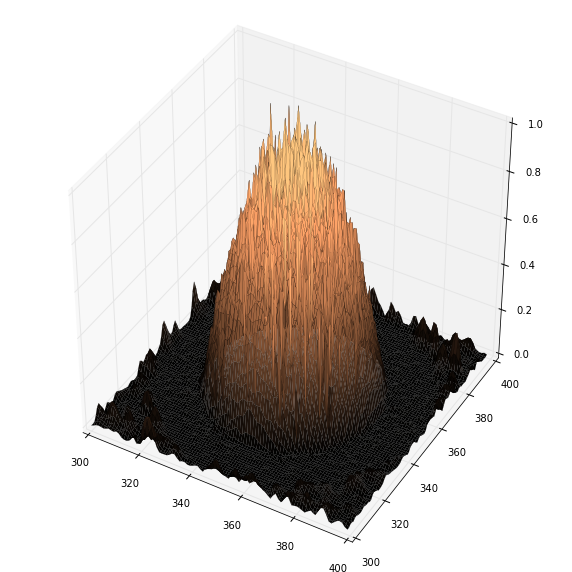

In [11]:
from mpl_toolkits.mplot3d import Axes3D

def quick_plot_3d(I_out):
    x = np.arange(300,400)
    x, y = np.meshgrid(x, x)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    ax.plot_surface(x, y, I_out[300:400,300:400], 
                    cmap=plt.get_cmap('copper'), 
                    rstride=1, 
                    cstride=1, 
                    linewidth=0.1,
                    clim=(0,1));
    ax.view_init(elev=40, azim=-60);
    ax.set_zlim(0,1)
       
quick_plot_3d(I_out)

Improvements
---------------

The plots above show a poor reconstruction of the target. 
The overall profile is correct, but there are many vortices arising from the discontinuity at the edge of the SLM plane. 
We can optimise for longer, and the vortices are pushed outwards from the target region:

In [12]:
start_time = timeit.default_timer()
scipy.optimize.fmin_cg(
    f=wrapped_cost_fn,
    x0=init_phi,
    fprime=wrapped_grad_fn,
    disp=True,
    maxiter=1000)
end_time = timeit.default_timer()
print('Ran for %.1fs' % ((end_time - start_time)))

         Current function value: 14.678343
         Iterations: 1000
         Function evaluations: 2002
         Gradient evaluations: 2002
Ran for 54.9s


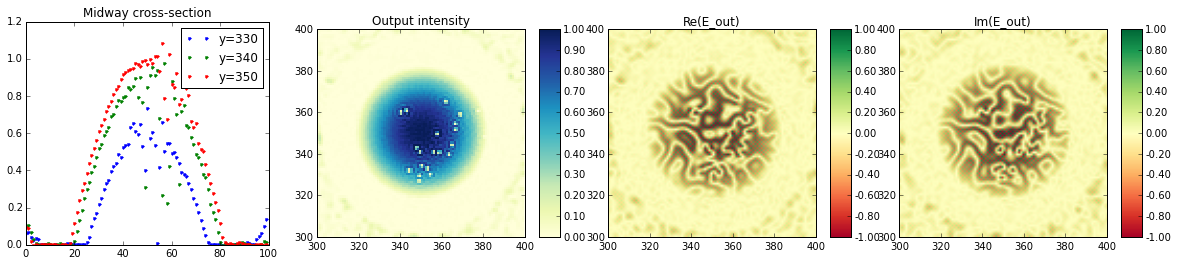

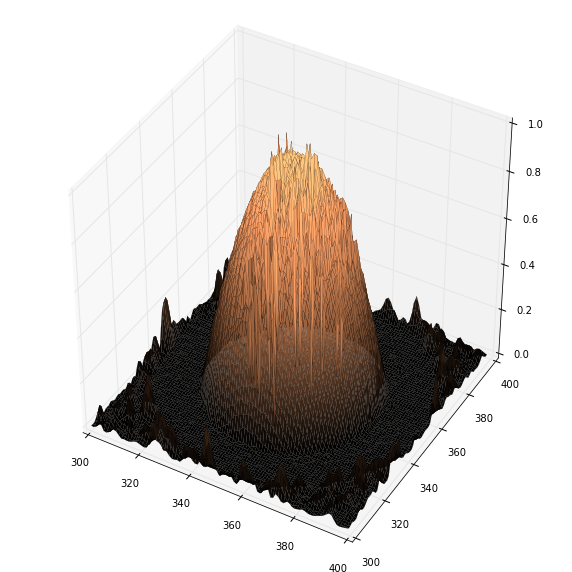

In [13]:
I_out = I_out_fn()
E_out_r = E_out_fn_r()
E_out_i = E_out_fn_i()

quick_plot(I_out, E_out_r, E_out_i)
quick_plot_3d(I_out)

This looks better, running for a little longer and we can reach a vortex-free reconstruction:

In [14]:
start_time = timeit.default_timer()
scipy.optimize.fmin_cg(
    f=wrapped_cost_fn,
    x0=init_phi,
    fprime=wrapped_grad_fn,
    disp=True,
    maxiter=5000)
end_time = timeit.default_timer()
print('Ran for %.1fs' % ((end_time - start_time)))

         Current function value: 0.005269
         Iterations: 5000
         Function evaluations: 10002
         Gradient evaluations: 10002
Ran for 270.6s


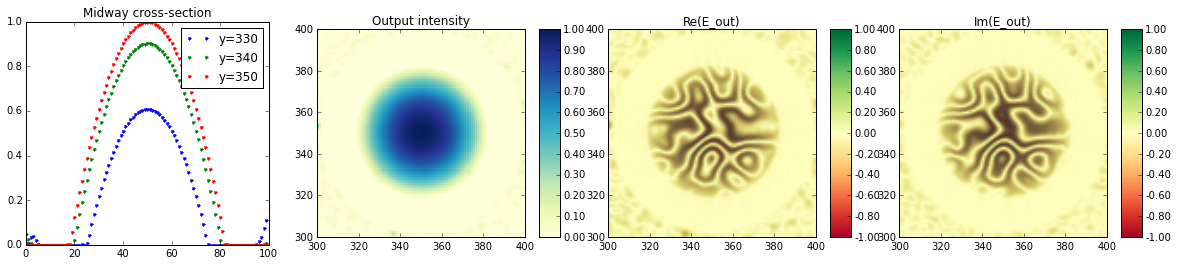

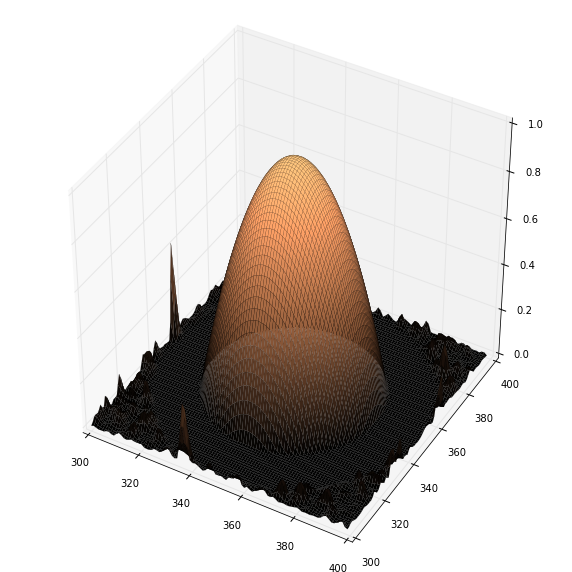

In [15]:
I_out = I_out_fn()
E_out_r = E_out_fn_r()
E_out_i = E_out_fn_i()

quick_plot(I_out, E_out_r, E_out_i)
quick_plot_3d(I_out)

## Further work ##

This short example has shown how conjugate-gradient optimisers can be efficiently be used to calculate an SLM phase profile $\phi_{ij}$ to reach a vortex-free target $T_{ij}$ in a very reasonable computational time. For more complex targets, and using more of the SLM plane, the optimisation problem becomes harder. In these cases, different choices of cost function can be very effective in converging to a solution. These are discussed extensively in [Harte et al (2014)](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-22-22-26548).

The key advantage of `theano` here is that these cost functions can be stated and differentiated **automatically**, enabling rapid development of more advanced potentials.